In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import TensorDataset, DataLoader
from sklearn import metrics
import seaborn as sns
from sklearn import metrics
import seaborn as sns

## The 6 labels UTD 
### LSTM

In [2]:
train_features = np.load('../Data/UTDMHAD_data/UTD_label_6_train_features.npy')
test_features = np.load('../Data/UTDMHAD_data/UTD_label_6_test_features.npy')
train_labels = np.load('../Data/UTDMHAD_data/UTD_label_6_train_labels.npy')
test_labels = np.load('../Data/UTDMHAD_data/UTD_label_6_test_labels.npy')

In [3]:
# Hyper parameter 
BATCH_SIZE = 32 # 
EPOCHES = 10

In [4]:
tensor_train_features = torch.Tensor(train_features) # torch.Size([688, 6, 128])
tensor_train_labels = torch.Tensor(train_labels)
tensor_test_features = torch.Tensor(test_features) # torch.Size([173, 6, 128])
tensor_test_labels = torch.Tensor(test_labels)

# Add one dimension of channel
tensor_train_features = torch.unsqueeze(tensor_train_features, 1)# (torch.Size([688, 1, 6, 128]),)
tensor_test_features = torch.unsqueeze(tensor_test_features, 1)
train_dataset = TensorDataset(tensor_train_features, tensor_train_labels)
test_dataset = TensorDataset(tensor_test_features, tensor_test_labels)
train_loader = torch.utils.data.DataLoader(dataset = train_dataset, batch_size = BATCH_SIZE, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset = test_dataset, batch_size = BATCH_SIZE, shuffle=True)

In [5]:
train_loader = torch.utils.data.DataLoader(dataset = train_dataset, batch_size = BATCH_SIZE, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset = test_dataset, batch_size = BATCH_SIZE, shuffle=True)

In [6]:
class LSTM_model(nn.Module):
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim):
        super(LSTM_model, self).__init__()
        self.hidden_dim = hidden_dim
        self.layer_dim = layer_dim
        self.lstm = nn.LSTM(input_dim, hidden_dim, layer_dim, batch_first = True)
        #FC_layer
        self.fc = nn.Linear(hidden_dim, output_dim)
        
    def forward(self, x):
        h0 = torch.zeros(self.layer_dim, x.size(0),self.hidden_dim).requires_grad_()#.to(device) 
        c0 = torch.zeros(self.layer_dim, x.size(0),self.hidden_dim).requires_grad_()#.to(device) 
        # X.SIZE = batch SIZE
        
        # detach the hidden state to prevent exploding gradient
        out, (hn,cn) = self.lstm(x,( h0.detach(),c0.detach()))# detach 
        out = self.fc(out[:, -1, :])# -1 the last layer state at time t     
        return out

In [7]:
input_dim = 128 # input dimension
hidden_dim = 1500 # hidden layers number
layer_dim = 1 
output_dim = 26 + 1 # output dimension

# initialize the model
model_lstm = LSTM_model(input_dim, hidden_dim, layer_dim, output_dim)

In [8]:
criterion = nn.CrossEntropyLoss()
learning_rate = 0.05
optimizer = torch.optim.SGD(model_lstm.parameters(), lr = learning_rate)

In [9]:
sequence_dim = 6
lost_list_LSTM = []
accuracy_list = []
iteration_list = [] 
iter = 0

for epoch in range(EPOCHES):
    for i, (images, labels) in enumerate(train_loader):
        model_lstm.train()
        # 32*1*6*128
        images = images.view(-1, sequence_dim, input_dim).requires_grad_()#.to(device)
        labels = labels.to(torch.int64)
        #labels = labels.to(device)
        # gradient.zero
        optimizer.zero_grad()
        #forward pass
        
        outputs = model_lstm(images)
        # print(output.size(), labels.size(), "pass")
        # loss calc
        loss_lstm = criterion(outputs, labels)
        # backword
        loss_lstm.backward()
        # renew the parameter
        optimizer.step()
        
        iter += 1
        if iter % 3 == 0:
            model_lstm.eval()
            # accuracy
            correct = 0
            total = 0
            for i, (images, labels) in enumerate(train_loader):
                    images = images.view(-1, sequence_dim, input_dim)#.to(device)
                    outputs = model_lstm(images)
                    #print(outputs.size())
                    
                    predict = torch.max(outputs.data, 1)[1]
                    total += labels.size(0)
                    correct += (predict == labels).sum()
            
            accuracy = correct / total * 100
            lost_list_LSTM.append(loss_lstm.data)
            accuracy_list.append(accuracy)
            iteration_list.append(iter)
            # print the info
            print("Iter:{},loss:{},Accuracy:{}".format(iter, loss_lstm.item(), accuracy))
        

Iter:3,loss:2.1231093406677246,Accuracy:91.30435180664062
Iter:6,loss:0.8281587362289429,Accuracy:96.52174377441406
Iter:9,loss:0.315183162689209,Accuracy:98.2608642578125
Iter:12,loss:0.3432824909687042,Accuracy:100.0
Iter:15,loss:0.2589222490787506,Accuracy:100.0
Iter:18,loss:0.1212582215666771,Accuracy:100.0
Iter:21,loss:0.09834835678339005,Accuracy:100.0
Iter:24,loss:0.06444938480854034,Accuracy:100.0
Iter:27,loss:0.09859553724527359,Accuracy:100.0
Iter:30,loss:0.049167972058057785,Accuracy:100.0
Iter:33,loss:0.03981907665729523,Accuracy:100.0
Iter:36,loss:0.05377115681767464,Accuracy:100.0
Iter:39,loss:0.03621845319867134,Accuracy:100.0


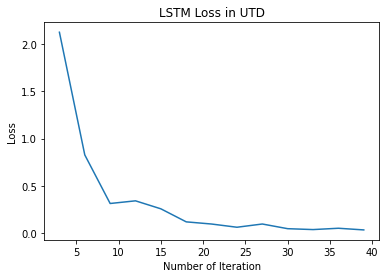

In [10]:
plt.plot(iteration_list,lost_list_LSTM)
plt.xlabel("Number of Iteration")
plt.ylabel("Loss")
plt.title("LSTM Loss in UTD")
plt.show()

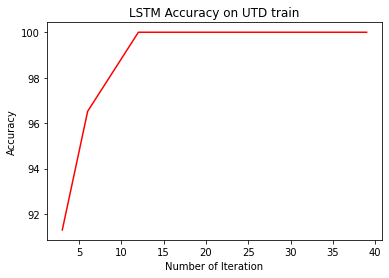

In [11]:
plt.plot(iteration_list,accuracy_list, color = "r")
plt.xlabel("Number of Iteration")
plt.ylabel("Accuracy")
plt.title("LSTM Accuracy on UTD train")
plt.show()

Test Accuracy of the basic LSTM model on the UTD test features: 84.41558837890625 %


Text(37.32, 0.5, 'predicted label')

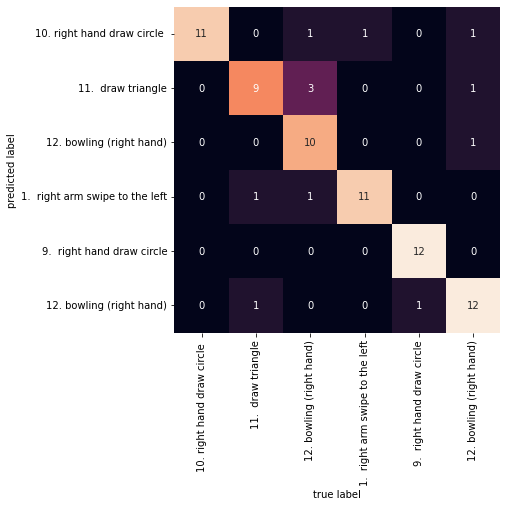

In [12]:
labels_list = []
predictions = []
classes = [
     '10. right hand draw circle ', 
    '11.  draw triangle', 
    '12. bowling (right hand)',
    '1.  right arm swipe to the left',
    '9.  right hand draw circle',
    '12. bowling (right hand)'
]

with torch.no_grad():
    correct = 0
    total = 0
    for i, (images, labels) in enumerate(test_loader):
        images = images.view(-1, sequence_dim, input_dim)#.to(device)
        outputs = model_lstm(images)
        #print(outputs.size())
                    
        predict = torch.max(outputs.data, 1)[1]
        total += labels.size(0)
        correct += (predict == labels).sum()
        predictions.append(predict)
        labels_list.append(labels)
    
    print('Test Accuracy of the basic LSTM model on the UTD test features: {} %'.format((correct / total) * 100))
    
mat = metrics.confusion_matrix(torch.cat(predictions), torch.cat(labels_list))

plt.figure(figsize=(6,6))
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=classes, yticklabels=classes)
plt.xlabel('true label')
plt.ylabel('predicted label')

### The 12 labels UTD

In [13]:
train_features = np.load('../Data/UTDMHAD_data/UTD_label_12_train_features.npy')
test_features = np.load('../Data/UTDMHAD_data/UTD_label_12_test_features.npy')
train_labels = np.load('../Data/UTDMHAD_data/UTD_label_12_train_labels.npy')
test_labels = np.load('../Data/UTDMHAD_data/UTD_label_12_test_labels.npy')

In [14]:
# Hyper parameter 
BATCH_SIZE = 32 # 
EPOCHES = 10

tensor_train_features = torch.Tensor(train_features) # torch.Size([688, 6, 128])
tensor_train_labels = torch.Tensor(train_labels)
tensor_test_features = torch.Tensor(test_features) # torch.Size([173, 6, 128])
tensor_test_labels = torch.Tensor(test_labels)

# Add one dimension of channel
tensor_train_features = torch.unsqueeze(tensor_train_features, 1)# (torch.Size([688, 1, 6, 128]),)
tensor_test_features = torch.unsqueeze(tensor_test_features, 1)
train_dataset = TensorDataset(tensor_train_features, tensor_train_labels)
test_dataset = TensorDataset(tensor_test_features, tensor_test_labels)
train_loader = torch.utils.data.DataLoader(dataset = train_dataset, batch_size = BATCH_SIZE, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset = test_dataset, batch_size = BATCH_SIZE, shuffle=True)

train_loader = torch.utils.data.DataLoader(dataset = train_dataset, batch_size = BATCH_SIZE, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset = test_dataset, batch_size = BATCH_SIZE, shuffle=True)

In [15]:
class LSTM_model(nn.Module):
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim):
        super(LSTM_model, self).__init__()
        self.hidden_dim = hidden_dim
        self.layer_dim = layer_dim
        self.lstm = nn.LSTM(input_dim, hidden_dim, layer_dim, batch_first = True)
        #FC_layer
        self.fc = nn.Linear(hidden_dim, output_dim)
        
    def forward(self, x):
        h0 = torch.zeros(self.layer_dim, x.size(0),self.hidden_dim).requires_grad_()#.to(device) 
        c0 = torch.zeros(self.layer_dim, x.size(0),self.hidden_dim).requires_grad_()#.to(device) 
        # X.SIZE = batch SIZE
        
        # detach the hidden state to prevent exploding gradient
        out, (hn,cn) = self.lstm(x,( h0.detach(),c0.detach()))# detach 
        out = self.fc(out[:, -1, :])# -1 the last layer state at time t     
        return out

In [16]:
input_dim = 128 # input dimension
hidden_dim = 1500 # hidden layers number
layer_dim = 1 
output_dim = 26 + 1 # output dimension

# initialize the model
model_lstm = LSTM_model(input_dim, hidden_dim, layer_dim, output_dim)

criterion = nn.CrossEntropyLoss()
learning_rate = 0.05
optimizer = torch.optim.SGD(model_lstm.parameters(), lr = learning_rate)

In [17]:
sequence_dim = 6
lost_list_LSTM = []
accuracy_list = []
iteration_list = [] 
iter = 0

for epoch in range(EPOCHES):
    for i, (images, labels) in enumerate(train_loader):
        model_lstm.train()
        # 32*1*6*128
        images = images.view(-1, sequence_dim, input_dim).requires_grad_()#.to(device)
        labels = labels.to(torch.int64)
        #labels = labels.to(device)
        # gradient.zero
        optimizer.zero_grad()
        #forward pass
        
        outputs = model_lstm(images)
        # print(output.size(), labels.size(), "pass")
        # loss calc
        loss_lstm = criterion(outputs, labels)
        # backword
        loss_lstm.backward()
        # renew the parameter
        optimizer.step()
        
        iter += 1
        if iter % 3 == 0:
            model_lstm.eval()
            # accuracy
            correct = 0
            total = 0
            for i, (images, labels) in enumerate(train_loader):
                    images = images.view(-1, sequence_dim, input_dim)#.to(device)
                    outputs = model_lstm(images)
                    #print(outputs.size())
                    
                    predict = torch.max(outputs.data, 1)[1]
                    total += labels.size(0)
                    correct += (predict == labels).sum()
            
            accuracy = correct / total * 100
            lost_list_LSTM.append(loss_lstm.data)
            accuracy_list.append(accuracy)
            iteration_list.append(iter)
            # print the info
            print("Iter:{},loss:{},Accuracy:{}".format(iter, loss_lstm.item(), accuracy))

Iter:3,loss:2.329324722290039,Accuracy:69.8689956665039
Iter:6,loss:1.7998706102371216,Accuracy:87.7729263305664
Iter:9,loss:1.2097160816192627,Accuracy:90.39301300048828
Iter:12,loss:0.9007238745689392,Accuracy:92.13973999023438
Iter:15,loss:0.4612754285335541,Accuracy:97.81658935546875
Iter:18,loss:0.4885999262332916,Accuracy:98.68995666503906
Iter:21,loss:0.3605383038520813,Accuracy:98.2532730102539
Iter:24,loss:0.3714526891708374,Accuracy:100.0
Iter:27,loss:0.2072744369506836,Accuracy:99.56331634521484
Iter:30,loss:0.24039234220981598,Accuracy:99.56331634521484
Iter:33,loss:0.1789044737815857,Accuracy:100.0
Iter:36,loss:0.10323859006166458,Accuracy:100.0
Iter:39,loss:0.14351806044578552,Accuracy:100.0
Iter:42,loss:0.05505771562457085,Accuracy:100.0
Iter:45,loss:0.08200281858444214,Accuracy:100.0
Iter:48,loss:0.15712520480155945,Accuracy:100.0
Iter:51,loss:0.07420740276575089,Accuracy:100.0
Iter:54,loss:0.0656757578253746,Accuracy:100.0
Iter:57,loss:0.04425688087940216,Accuracy:100.

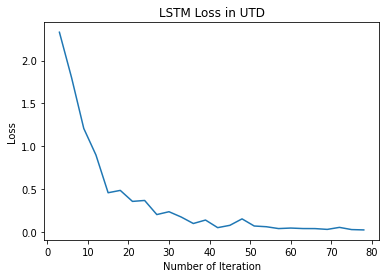

In [18]:
plt.plot(iteration_list,lost_list_LSTM)
plt.xlabel("Number of Iteration")
plt.ylabel("Loss")
plt.title("LSTM Loss in UTD")
plt.show()

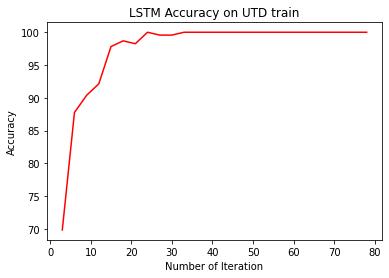

In [19]:
plt.plot(iteration_list,accuracy_list, color = "r")
plt.xlabel("Number of Iteration")
plt.ylabel("Accuracy")
plt.title("LSTM Accuracy on UTD train")
plt.show()

Test Accuracy of the basic LSTM model on the UTD test features: 86.2745132446289 %


Text(37.31999999999999, 0.5, 'predicted label')

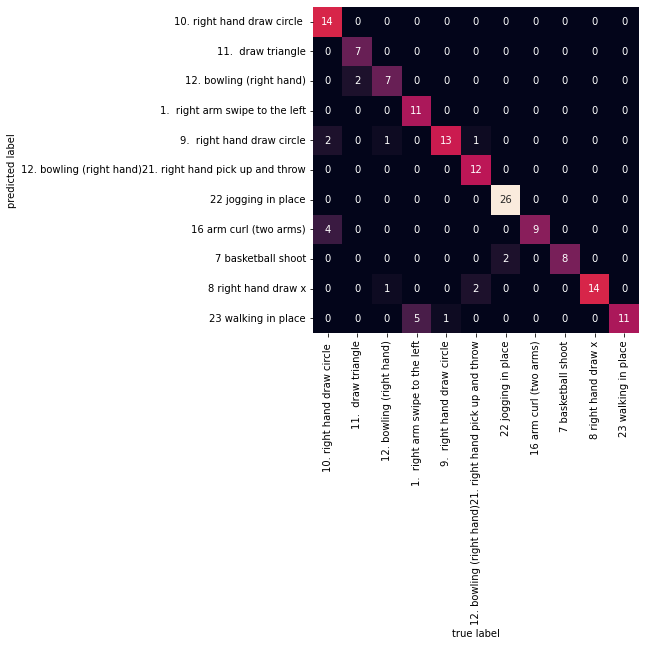

In [20]:
labels_list = []
predictions = []

classes = [
     '10. right hand draw circle ', 
    '11.  draw triangle', 
    '12. bowling (right hand)',
    '1.  right arm swipe to the left',
    '9.  right hand draw circle',
    '12. bowling (right hand)'
    '21. right hand pick up and throw',
    '22 jogging in place',
    '16 arm curl (two arms)', 
    '7 basketball shoot', 
    '8 right hand draw x', 
    '23 walking in place'
]

with torch.no_grad():
    correct = 0
    total = 0
    for i, (images, labels) in enumerate(test_loader):
        images = images.view(-1, sequence_dim, input_dim)#.to(device)
        outputs = model_lstm(images)
        #print(outputs.size())
                    
        predict = torch.max(outputs.data, 1)[1]
        total += labels.size(0)
        correct += (predict == labels).sum()
        predictions.append(predict)
        labels_list.append(labels)
    
    print('Test Accuracy of the basic LSTM model on the UTD test features: {} %'.format((correct / total) * 100))
    
mat = metrics.confusion_matrix(torch.cat(predictions), torch.cat(labels_list))

plt.figure(figsize=(6,6))
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=classes, yticklabels=classes)
plt.xlabel('true label')
plt.ylabel('predicted label')